In [2]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.style.use('ggplot')

In [3]:
df = pd.read_csv("energydata_complete.csv", parse_dates=['date'])

In [4]:
df.columns = [x.lower() for x in df.columns]
df.isna().any()
df = df.set_index('date')

# Feature Engineering

Check for outliers: Consider the top 0.1% values 

The number of the 0,1% top values of appliances' load is 19 and they have power load higher than 790 Wh.


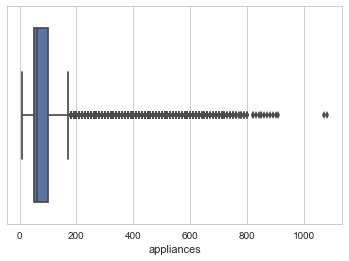

In [5]:
sorted_appliances = df.sort_values('appliances',ascending=False)
print("The number of the 0,1% top values of appliances' load is",
      len(sorted_appliances.head(len(sorted_appliances)//1000)),"and they have power load higher than",
      sorted_appliances.appliances[19], "Wh.")

sns.set(style="whitegrid")
ax = sns.boxplot(sorted_appliances.appliances)

In [6]:
df = df.dropna()
df = df.drop(df[(df.appliances>790)|(df.appliances<0)].index)

The idea is that appliances' load is hour, day, week, month dependent. It is logical assumption that in night hours the load is low or at weekends the energy consumption is higher than the weekdays because more people are at home.

Additionaly, it is expected a correlation between temperature/humidity and energy load. For instance, when someone cooks(higher consumption) probably the temperature in the kichen raises.

Moreover, we can use qualitative predictors to indicate if a measured load is lower or higher in comparison to the average energy load a given time interval.


In [7]:
df['month'] = df.index.month
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour
df['week'] = df.index.week


In [8]:
df['log_appliances'] = np.log(df.appliances)

# Average house temperature and humidity
df['house_temp'] =(df.t1+df.t2+df.t3+df.t4+df.t5+df.t7+df.t8+df.t9)/8
df['house_hum'] =(df.rh_1+df.rh_2+df.rh_3+df.rh_4+df.rh_5+df.rh_7+df.rh_8+df.rh_9)/8


# Products of several features to remove additive assumption
df['hour*lights'] = df.hour * df.lights
df['t3rh3'] = df.t3 * df.rh_3
df['t2rh2'] = df.t2 * df.rh_2
df['t1rh1'] = df.t2 * df.rh_2
df['t5rh4'] = df.t2 * df.rh_2
df['t5rh5'] = df.t2 * df.rh_2
df['t6rh6'] = df.t2 * df.rh_2
df['t7rh7'] = df.t2 * df.rh_2
df['t8rh8'] = df.t2 * df.rh_2
df['t9rh9'] = df.t2 * df.rh_2

# Calculate average energy load per weekday and hour
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

# Average energy consumption per weekday and hour
df['weekday_avg'] = list(map(
    code_mean(df[:], 'weekday', "appliances").get, df.weekday))
df['hour_avg'] = list(map(
    code_mean(df[:], 'hour', "appliances").get, df.hour))

In [9]:
df_hour = df.resample('1H').mean()
df_30min =df.resample('30min').mean()

In [10]:
# Qualitative predictors 
'''We assume that we have low(high) energy load when the appliances consumption is lower(higher) 
   than a given point of the hourly average counsumption. This point is dependent of data time frequency 
   and the numbers below are set after several tryouts based on appliances' consumption standard deviation.
'''

df['low_consum'] = (df.appliances+25<(df.hour_avg))*1
df['high_consum'] = (df.appliances+100>(df.hour_avg))*1

df_hour['low_consum'] = (df_hour.appliances+25<(df_hour.hour_avg))*1
df_hour['high_consum'] = (df_hour.appliances+25>(df_hour.hour_avg))*1

df_30min['low_consum'] = (df_30min.appliances+25<(df_30min.hour_avg))*1
df_30min['high_consum'] = (df_30min.appliances+35>(df_30min.hour_avg))*1

Text(0,0.5,'Appliances consumption in Wh')

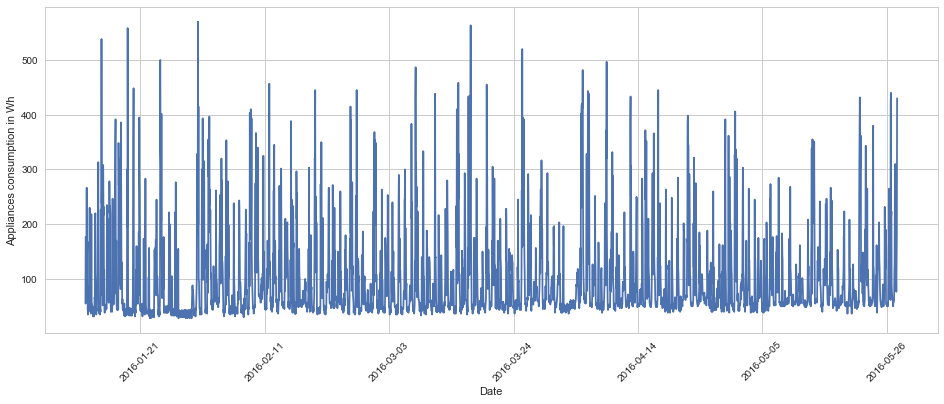

In [11]:
plt.figure(figsize=(16,6))
plt.plot(df_hour.appliances)
plt.xticks( rotation='45')
plt.xlabel('Date')
plt.ylabel('Appliances consumption in Wh')

In [12]:
def daily(x,df=df):
    return df.groupby('weekday')[x].mean()
def hourly(x,df=df):
    return df.groupby('hour')[x].mean()

def monthly_daily(x,df=df):
    by_day = df.pivot_table(index='weekday', 
                                columns=['month'],
                                values=x,
                                aggfunc='mean')
    return round(by_day, ndigits=2)

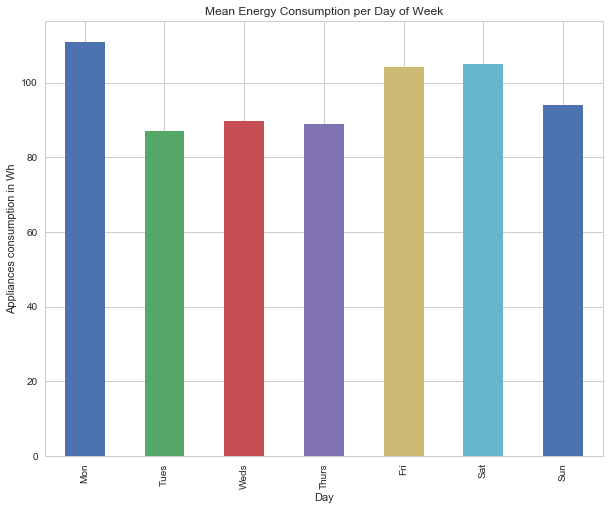

In [13]:
# Plot of Mean Energy Consumption per Day of Week

daily('appliances').plot(kind = 'bar', figsize=(10,8))
ticks = list(range(0, 7, 1)) 
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xlabel('Day')
plt.ylabel('Appliances consumption in Wh')
plt.title('Mean Energy Consumption per Day of Week')
plt.xticks(ticks, labels);

([<matplotlib.axis.XTick at 0x1bc83d95128>,
 <a list of 24 Text xticklabel objects>)

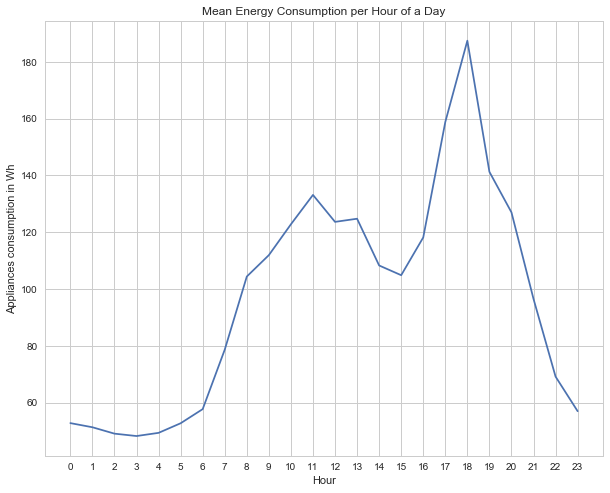

In [14]:
# Plot of Mean Energy Consumption per Hour of a Day

hourly('appliances').plot(figsize=(10,8))
plt.xlabel('Hour')
plt.ylabel('Appliances consumption in Wh')
ticks = list(range(0, 24, 1))
plt.title('Mean Energy Consumption per Hour of a Day')

plt.xticks(ticks)

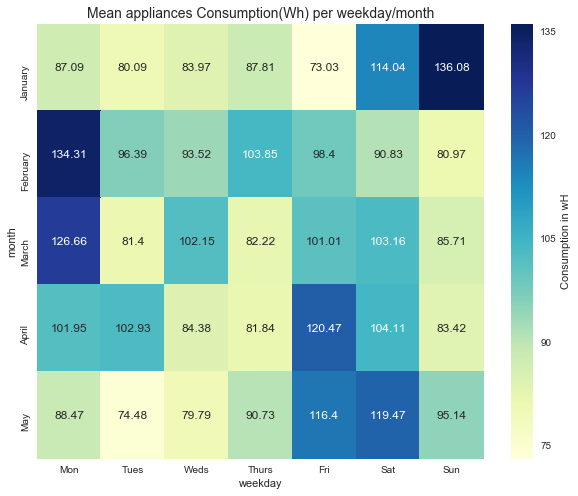

In [15]:
# Heatmap: Mean consumption per Weekday of Month
sns.set(rc={'figure.figsize':(10,8)},)
ax=sns.heatmap(monthly_daily('appliances').T,cmap="YlGnBu",
               xticklabels="Mon Tues Weds Thurs Fri Sat Sun".split(),
               yticklabels="January February March April May".split(),
               annot=True, fmt='g',
               cbar_kws={'label': 'Consumption in wH'}).set_title("Mean appliances Consumption(Wh) per weekday/month").set_fontsize('14')

plt.show()

Text(0.5,0,'Appliances log(wH)')

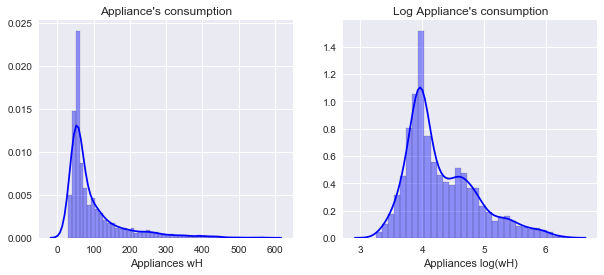

In [16]:
#Histogram of Appliance's consumption

f, axes = plt.subplots(1, 2,figsize=(10,4))

sns.distplot(df_hour.appliances, hist=True, color = 'blue',hist_kws={'edgecolor':'black'},ax=axes[0])
axes[0].set_title("Appliance's consumption")
axes[0].set_xlabel('Appliances wH')

sns.distplot(df_hour.log_appliances, hist=True, color = 'blue',hist_kws={'edgecolor':'black'},ax=axes[1])
axes[1].set_title("Log Appliance's consumption")
axes[1].set_xlabel('Appliances log(wH)')

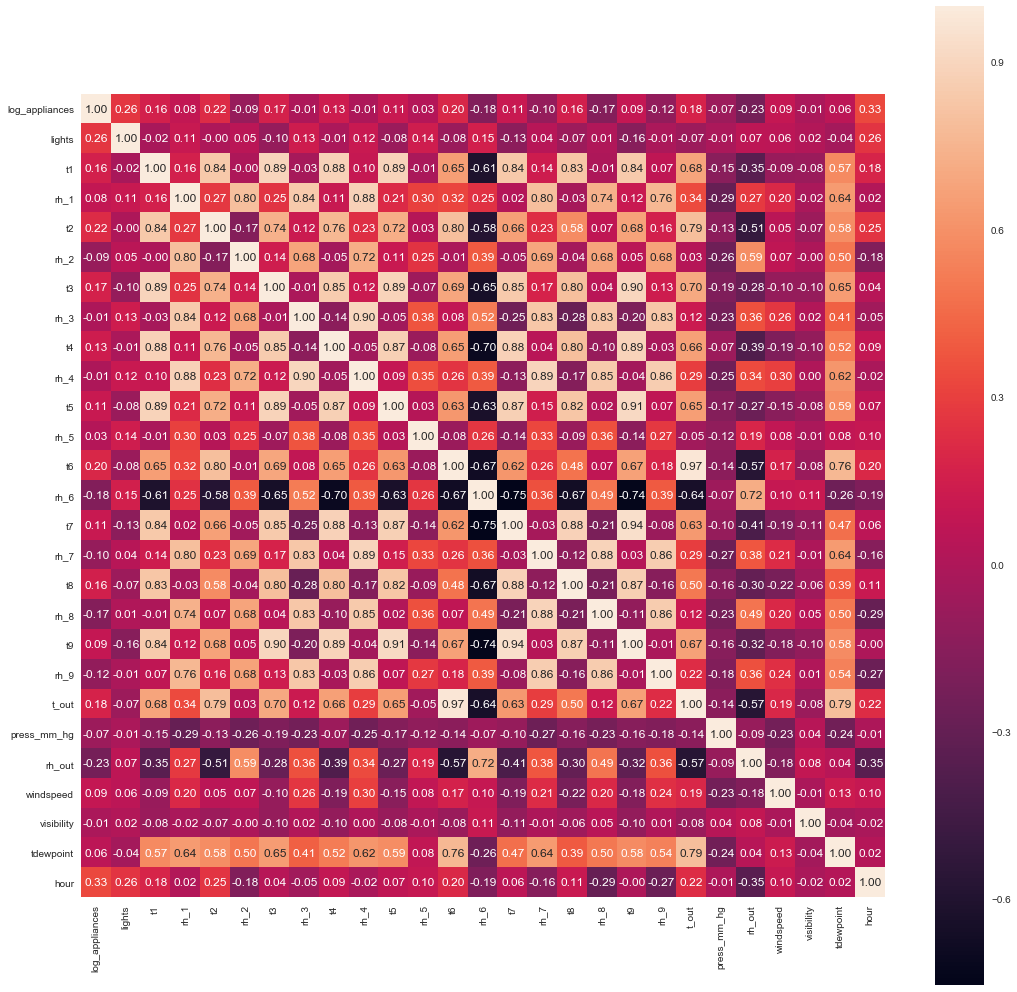

In [17]:
# Pearson Correlation among the variables
col = ['log_appliances', 'lights', 't1', 'rh_1', 't2', 'rh_2', 't3', 'rh_3', 't4',
       'rh_4', 't5', 'rh_5', 't6', 'rh_6', 't7', 'rh_7', 't8', 'rh_8', 't9',
       'rh_9', 't_out', 'press_mm_hg', 'rh_out', 'windspeed', 'visibility',
       'tdewpoint','hour']
corr = df[col].corr()
plt.figure(figsize = (18,18))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels=col, yticklabels=col)
plt.show()

The most correlated features with energy consumtion(log_appliances) are: hour=0.33, lights=0.26, t6=0.20, t2=0.22, t3 = 0.17,t_out = 0.18, rh_out = -0.23, rh_8 = -0.17, rh_6 = -0.18, windspeed = 0.09

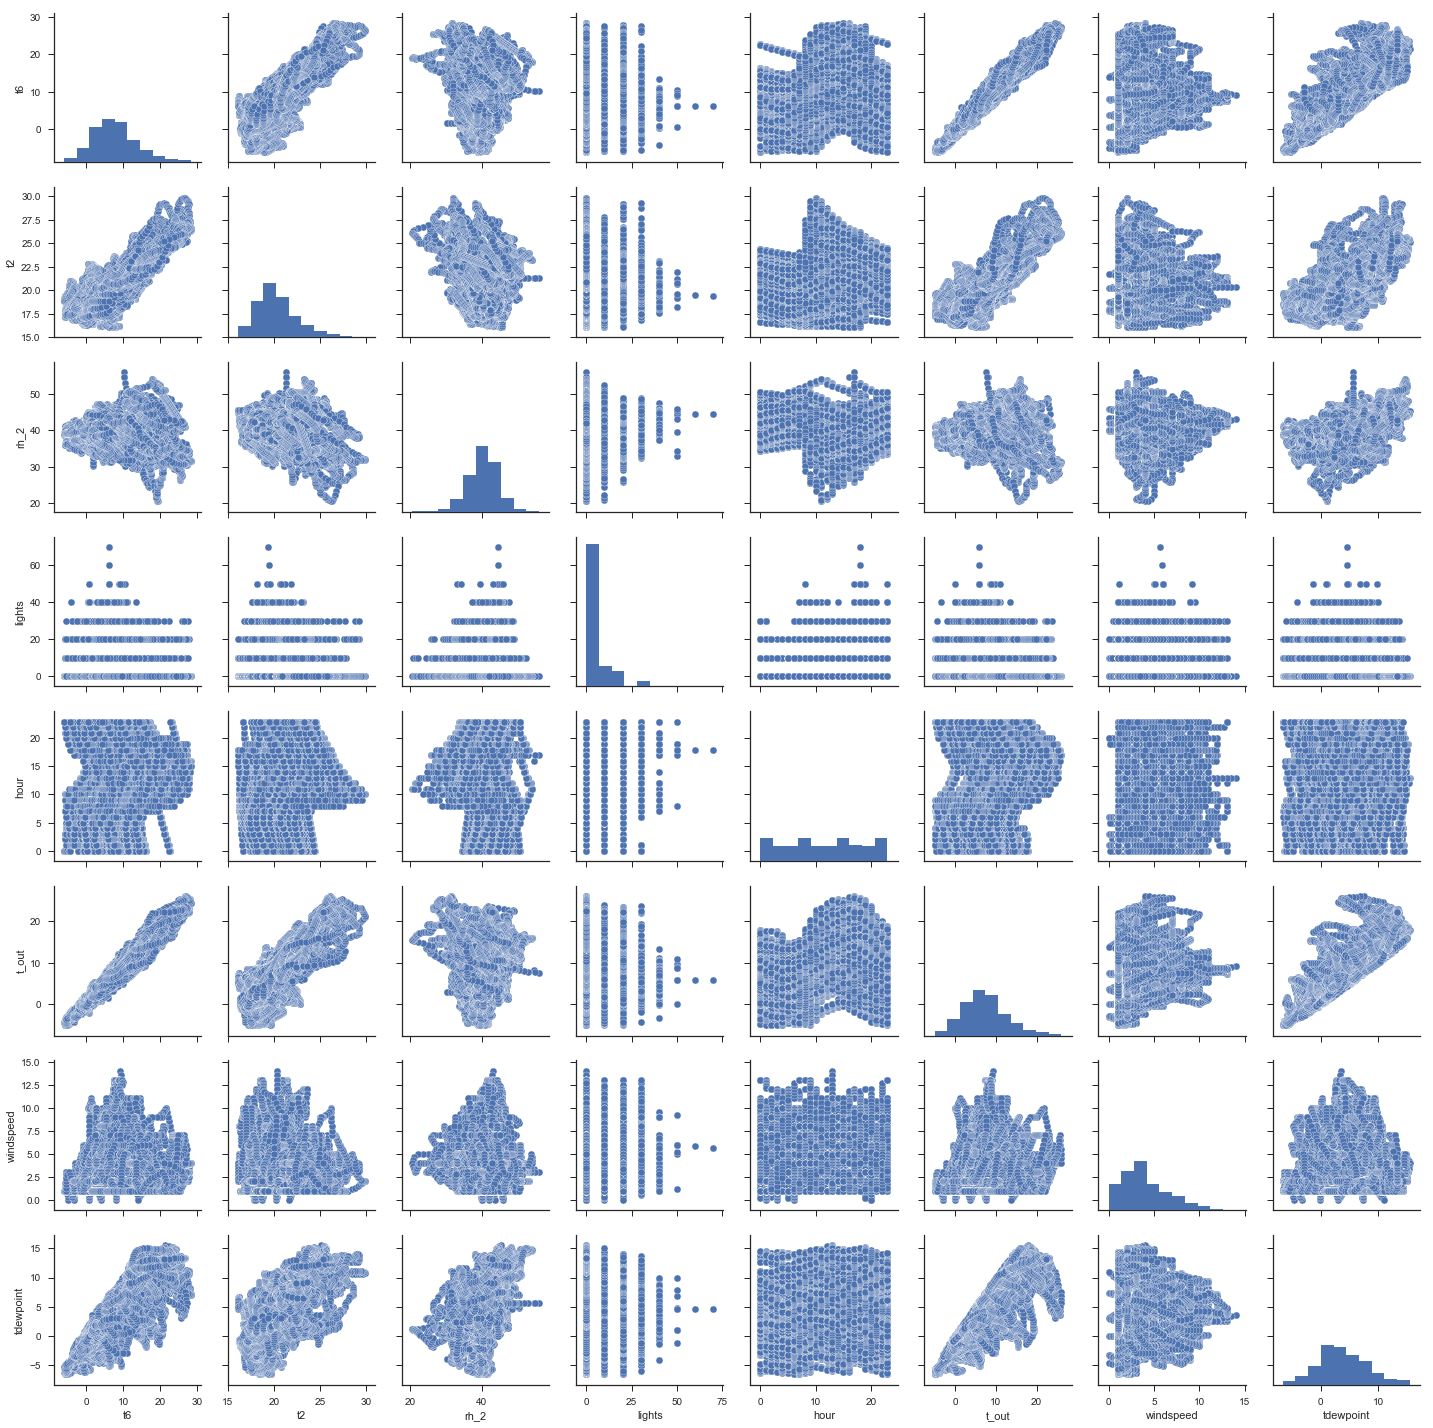

In [19]:
'''Below we examine linear dependence among some basic features of our data set. 
In a linear regression problem only linear independent variables can be be used as features to explain energy consumption 
in other way we will have multicolinearity issues.'''

col = ['t6','t2', 'rh_2','lights','hour','t_out','windspeed','tdewpoint']
sns.set(style="ticks", color_codes=True)
sns.pairplot(df[col])
plt.show();

We can see from the plots above that temperatures (in or out) and tdewpoint have linear relationship. For this reason I will use only a temperature in house as feature to the linear model. Addionally, I will choose the temperature and the humidity from the room which have the maximum correlation with the appliances' load.

# Training

In [20]:
#Changing categorical variables


for cat_feature in ['weekday', 'hour']:
    df_hour = pd.concat([df_hour, pd.get_dummies(df_hour[cat_feature])], axis=1)
    df_30min = pd.concat([df_30min, pd.get_dummies(df_30min[cat_feature])], axis=1)
    df = pd.concat([df, pd.get_dummies(df[cat_feature])], axis=1)

In [21]:
model1 = ['low_consum','high_consum','hour','t6','rh_6','lights','hour*lights','windspeed','t6rh6']
df_hour.lights = df_hour.lights.astype(float)
df_hour.log_appliances = df_hour.log_appliances.astype(float)
df_hour.hour = df_hour.hour.astype(float)
df_hour.low_consum = df_hour.low_consum.astype(float)
df_hour.high_consum = df_hour.high_consum.astype(float)
df_hour.t6rh6 = df_hour.t6rh6.astype(float)

In [23]:
test_size=.2
test_index = int(len(df_hour.dropna())*(1-test_size))

X1_train, X1_test = df_hour[model1].iloc[:test_index,], df_hour[model1].iloc[test_index:,]
y1_train = df_hour.log_appliances.iloc[:test_index,]
y_test =  df_hour.log_appliances.iloc[test_index:,]


In [24]:
from sklearn.preprocessing import StandardScaler

# Normalizing of X matrices for each model to mean = 0 and standard deviation = 1

scaler = StandardScaler()
scaler.fit(X1_train)
X1_train = scaler.transform(X1_train)
X1_test = scaler.transform(X1_test)

In [37]:
from sklearn import linear_model

lin_model = linear_model.LinearRegression()
lin_model.fit(X1_train,y1_train)
ridge_model = linear_model.Ridge()
ridge_model.fit(X1_train,y1_train)
lasso_model = linear_model.Lasso()
lasso_model.fit(X1_train, y1_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

# Evaluation

In [38]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [39]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    r_score = 100*r2_score(test_labels,predictions)
    accuracy = 100 - mape
    print(model,'\n')
    print('Average Error       : {:0.4f} degrees'.format(np.mean(errors)))
    print('Variance score R^2  : {:0.2f}%' .format(r_score))
    print('Accuracy            : {:0.2f}%\n'.format(accuracy))

In [40]:
evaluate(lin_model, X1_test, y_test)
evaluate (ridge_model, X1_test, y_test)
evaluate (lasso_model, X1_test, y_test)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 

Average Error       : 0.3093 degrees
Variance score R^2  : 28.15%
Accuracy            : 92.92%

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001) 

Average Error       : 0.3094 degrees
Variance score R^2  : 28.16%
Accuracy            : 92.91%

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) 

Average Error       : 0.3784 degrees
Variance score R^2  : -1.74%
Accuracy            : 91.67%



Cross Validation

We will use as metric both R^2 and negative mean absolute error. Models' accuracy (MAPE) derives from the type: 100 + negative mean absolute error with perfect score 100.

In [41]:
from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(n_splits = 10)


print('Linear Model:')
scores = cross_val_score(lin_model, X1_train, y1_train, cv=cv,scoring='neg_mean_absolute_error')
print("Accuracy: %0.2f (+/- %0.2f) degrees" % (100+scores.mean(), scores.std() * 2))
scores = cross_val_score(lin_model, X1_train, y1_train, cv=cv,scoring='r2')
print("R^2: %0.2f (+/- %0.2f) degrees" % (scores.mean(), scores.std() * 2))

print('Ridge Model:')
scores = cross_val_score(ridge_model, X1_train, y1_train, cv=cv,scoring='neg_mean_absolute_error')
print("Accuracy: %0.2f (+/- %0.2f) degrees" % (100+scores.mean(), scores.std() * 2))
scores = cross_val_score(ridge_model, X1_train, y1_train, cv=cv,scoring='r2')
print("R^2: %0.2f (+/- %0.2f) degrees" % (scores.mean(), scores.std() * 2))

print('Lasso Model:')
scores = cross_val_score(lasso_model, X1_train, y1_train, cv=cv,scoring='neg_mean_absolute_error')
print("Accuracy: %0.2f (+/- %0.2f) degrees" % (100+scores.mean(), scores.std() * 2))
scores = cross_val_score(lasso_model, X1_train, y1_train, cv=cv,scoring='r2')
print("R^2: %0.2f (+/- %0.2f) degrees" % (scores.mean(), scores.std() * 2))

Linear Model:
Accuracy: 99.64 (+/- 0.07) degrees
R^2: 0.27 (+/- 0.18) degrees
Ridge Model:
Accuracy: 99.64 (+/- 0.07) degrees
R^2: 0.27 (+/- 0.17) degrees
Lasso Model:
Accuracy: 99.54 (+/- 0.13) degrees
R^2: -0.04 (+/- 0.11) degrees


In [42]:
y1_pred = lin_model.predict(X1_test)
y2_pred = ridge_model.predict(X1_test)
y3_pred = lasso_model.predict(X1_test)

Text(0.5,1,'Lasso Regression')

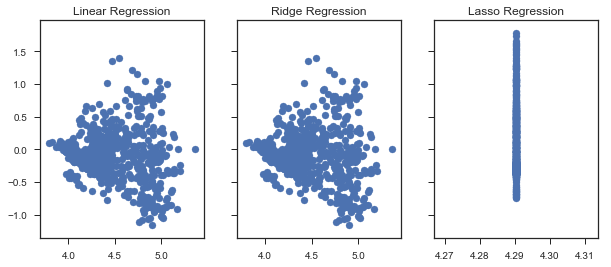

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(10,4), sharey=True)
axs[0].scatter(y1_pred,y_test-y1_pred)
axs[0].set_title('Linear Regression')
axs[1].scatter(y2_pred,y_test-y2_pred)
axs[1].set_title('Ridge Regression')
axs[2].scatter(y3_pred,y_test-y3_pred)
axs[2].set_title('Lasso Regression')

Text(0.5,1,'Lasso Regression')

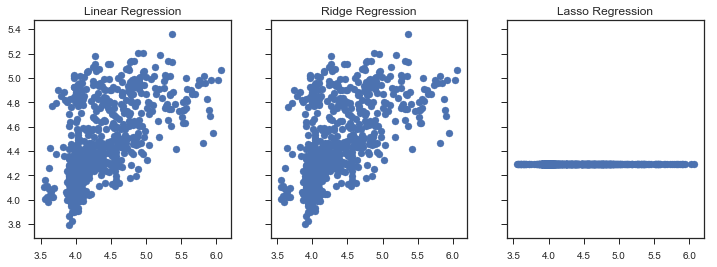

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(12,4), sharey=True)
axs[0].scatter(y_test,y1_pred)
axs[0].set_title('Linear Regression')
axs[1].scatter(y_test,y2_pred)
axs[1].set_title('Ridge Regression')
axs[2].scatter(y_test,y3_pred)
axs[2].set_title('Lasso Regression')

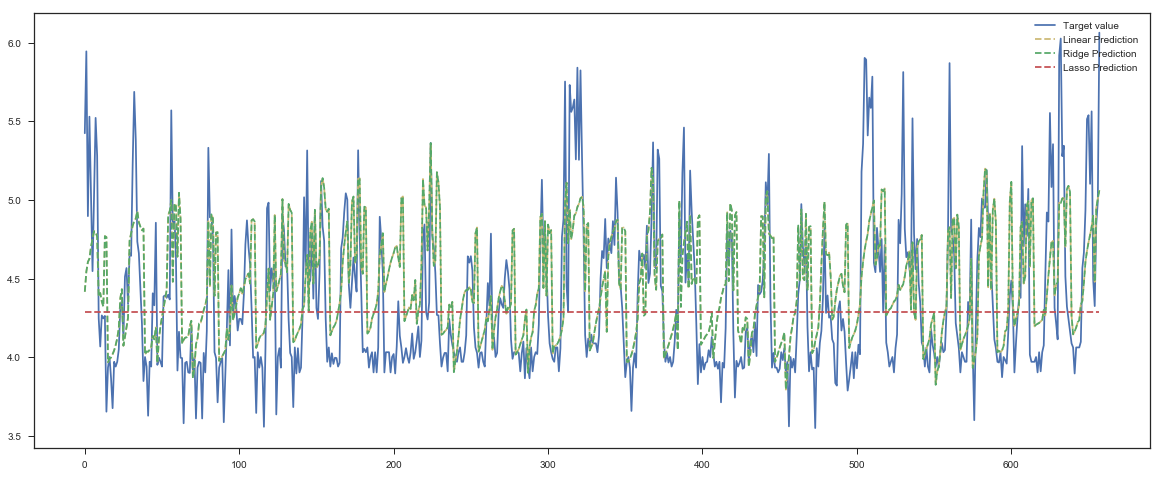

In [45]:
fig = plt.figure(figsize=(20,8))
plt.plot(y_test.values,label='Target value',color='b')
plt.plot(y1_pred,label='Linear Prediction ', linestyle='--', color='y')
plt.plot(y2_pred,label='Ridge Prediction ', linestyle='--', color='g')
plt.plot(y3_pred,label='Lasso Prediction ', linestyle='--', color='r')

plt.legend(loc=1)


# Ridge and Lasso Regression